In [1]:
# https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import gc
from tensorflow.python.client import device_lib 
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder




import sys

sys.path.append("src/")
from model.evaluation import create_results_df
from model.nn_models import create_model_LSTM_with_Attention, create_model_MLP, create_model_KAN
from model.config import create_experiment_configs_tf
from data.preparation import load_dataset,prepare_data 



# Configuration
DATA_DIR = 'data/'
PATH_REPORTS = 'reports/'
PATH_MODELS = 'models/'
PATH_LOGS = "logs"

ASSETS = [
    "PETR3.SA", 
    "PRIO3.SA", 
    "VALE3.SA", 
    "GGBR3.SA", 
    "ABCB4.SA", 
    "ITUB3.SA", 
    "FLRY3.SA", 
    "RADL3.SA"
    ]

seq_len_list = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,14,21,28,35,42,49,56,63,70
    ]

dict_experiments = {}

exp_id = 0

moving_windows = [
    7,
    14,
    21
    ]

                            
dict_experiments = create_experiment_configs_tf(ASSETS, seq_len_list, moving_windows)

check_if_already_exists = True

def main():
   
    print(device_lib.list_local_devices())
    print("TensorFlow Version: ", tf.__version__)
    
    progress = 0
    for exp_name, config in dict_experiments.items():
        
        progress += 1
        
        print(f"""
#####################################
Running {progress}/{len(dict_experiments)}
Config:
{config}
#####################################
""")
        
        feature_cols = config['feature_cols']
        label_col = config['label_col']
        seq_len = config['seq_len']
        asset = config['asset']
        scaling_method = config['scaling_method']
        algorithm = config['algorithm']
        prediction_type = config['prediction_type']
        

        path_results = PATH_REPORTS + f'test_results/{algorithm}_{asset.replace(".", "_")}_features={"_".join(feature_cols)}__label={label_col}__sql_len={seq_len}__scaling_method={scaling_method.__str__()}_test_results.csv'
        
        if os.path.isfile(path_results) and check_if_already_exists:
            print('# experiment already done')
            continue
        
        
        dataset = load_dataset(asset, DATA_DIR)
        X_train, X_test, y_train, y_test = prepare_data(dataset, seq_len, feature_cols, label_col, scaling_method)
        
        
        if prediction_type=='regression':
            
            num_classes = None
            
            if algorithm in ['MLP', 'LSTM']:
                callbacks = [
                    EarlyStopping(monitor='val_r2_score', patience=10, mode='max'),
                    # ModelCheckpoint(PATH_MODELS + f'best_model_LSTM_with_Attention_{asset.replace(".", "_")}.keras', save_best_only=True, monitor='val_r2_score'),
                    ReduceLROnPlateau(monitor='val_r2_score', factor=0.1, patience=5, mode='max'),
                    TensorBoard(log_dir=PATH_LOGS),
                    CSVLogger(PATH_MODELS + f'training_log_{algorithm}_{asset.replace(".", "_")}_features={"_".join(feature_cols)}__label={label_col}__sql_len={seq_len}_test_results.csv')
                ]   
            elif algorithm == 'KAN':
                # nao sei se é necessario fazer algo aqui
                # preencher
                # tenho que verificar se a entrada sao arrays numpy
                pass
            
            else: raise ValueError(f'Algoritmo errado selecionado para {prediction_type}')
            
        elif prediction_type=='classification':
            num_classes = len(np.unique(y_train))
            
            if algorithm in ['MLP, LSTM']:
                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=10, mode = 'min'),
                    # ModelCheckpoint(PATH_MODELS + f'best_model_LSTM_with_Attention_{asset.replace(".", "_")}.keras', save_best_only=True, monitor='val_r2_score'),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,mode = 'min'),
                    TensorBoard(log_dir=PATH_LOGS),
                    CSVLogger(PATH_MODELS + f'training_log_{algorithm}_{asset.replace(".", "_")}_features={"_".join(feature_cols)}__label={label_col}__sql_len={seq_len}_test_results.csv')
                ]

                # Convertendo os rótulos para one-hot encoding
                y_train = to_categorical(y_train, num_classes=num_classes)
                #y_test = to_categorical(y_test, num_classes=num_classes)
                
            elif algorithm == 'KAN':
                # preencher
                # fazer processamento dos dados de rotulo que nao é pra estar em to_categorical,
                # mas sim em squeeze
                # e tbm tenho que verificar se entradas sao arrays numpy
                pass
                
            else: raise ValueError(f'Algoritmo errado selecionado para {prediction_type}')

            
        else: raise ValueError(f'Não existe prediction_type = {prediction_type}')
            
        
        if algorithm == 'LSTM_with_Attention':
            model = create_model_LSTM_with_Attention(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                num_classes=num_classes
                )
        elif algorithm == 'MLP':
            model = create_model_MLP(
                input_shape=(X_train.shape[1], X_train.shape[2]),
                num_classes=num_classes
                )

2024-10-27 06:16:59.190532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 06:16:59.251468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 06:16:59.270010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 06:16:59.376403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 06:17:00.728452: W tensorflow/compiler/tf2

NameError: name 'set_seed' is not defined

In [1]:
import sys
sys.path.append("../src/")
from model.nn_models import create_model_LSTM_with_Attention, create_model_MLP
from tensorflow.keras.utils import plot_model

2024-10-27 06:23:18.195868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 06:23:18.213828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 06:23:18.220160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 06:23:18.233668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 06:23:19.543148: W tensorflow/compiler/tf2

In [6]:
model = create_model_LSTM_with_Attention(
    input_shape=(2, 3),
    num_classes=None
    )


ValueError: object __array__ method not producing an array

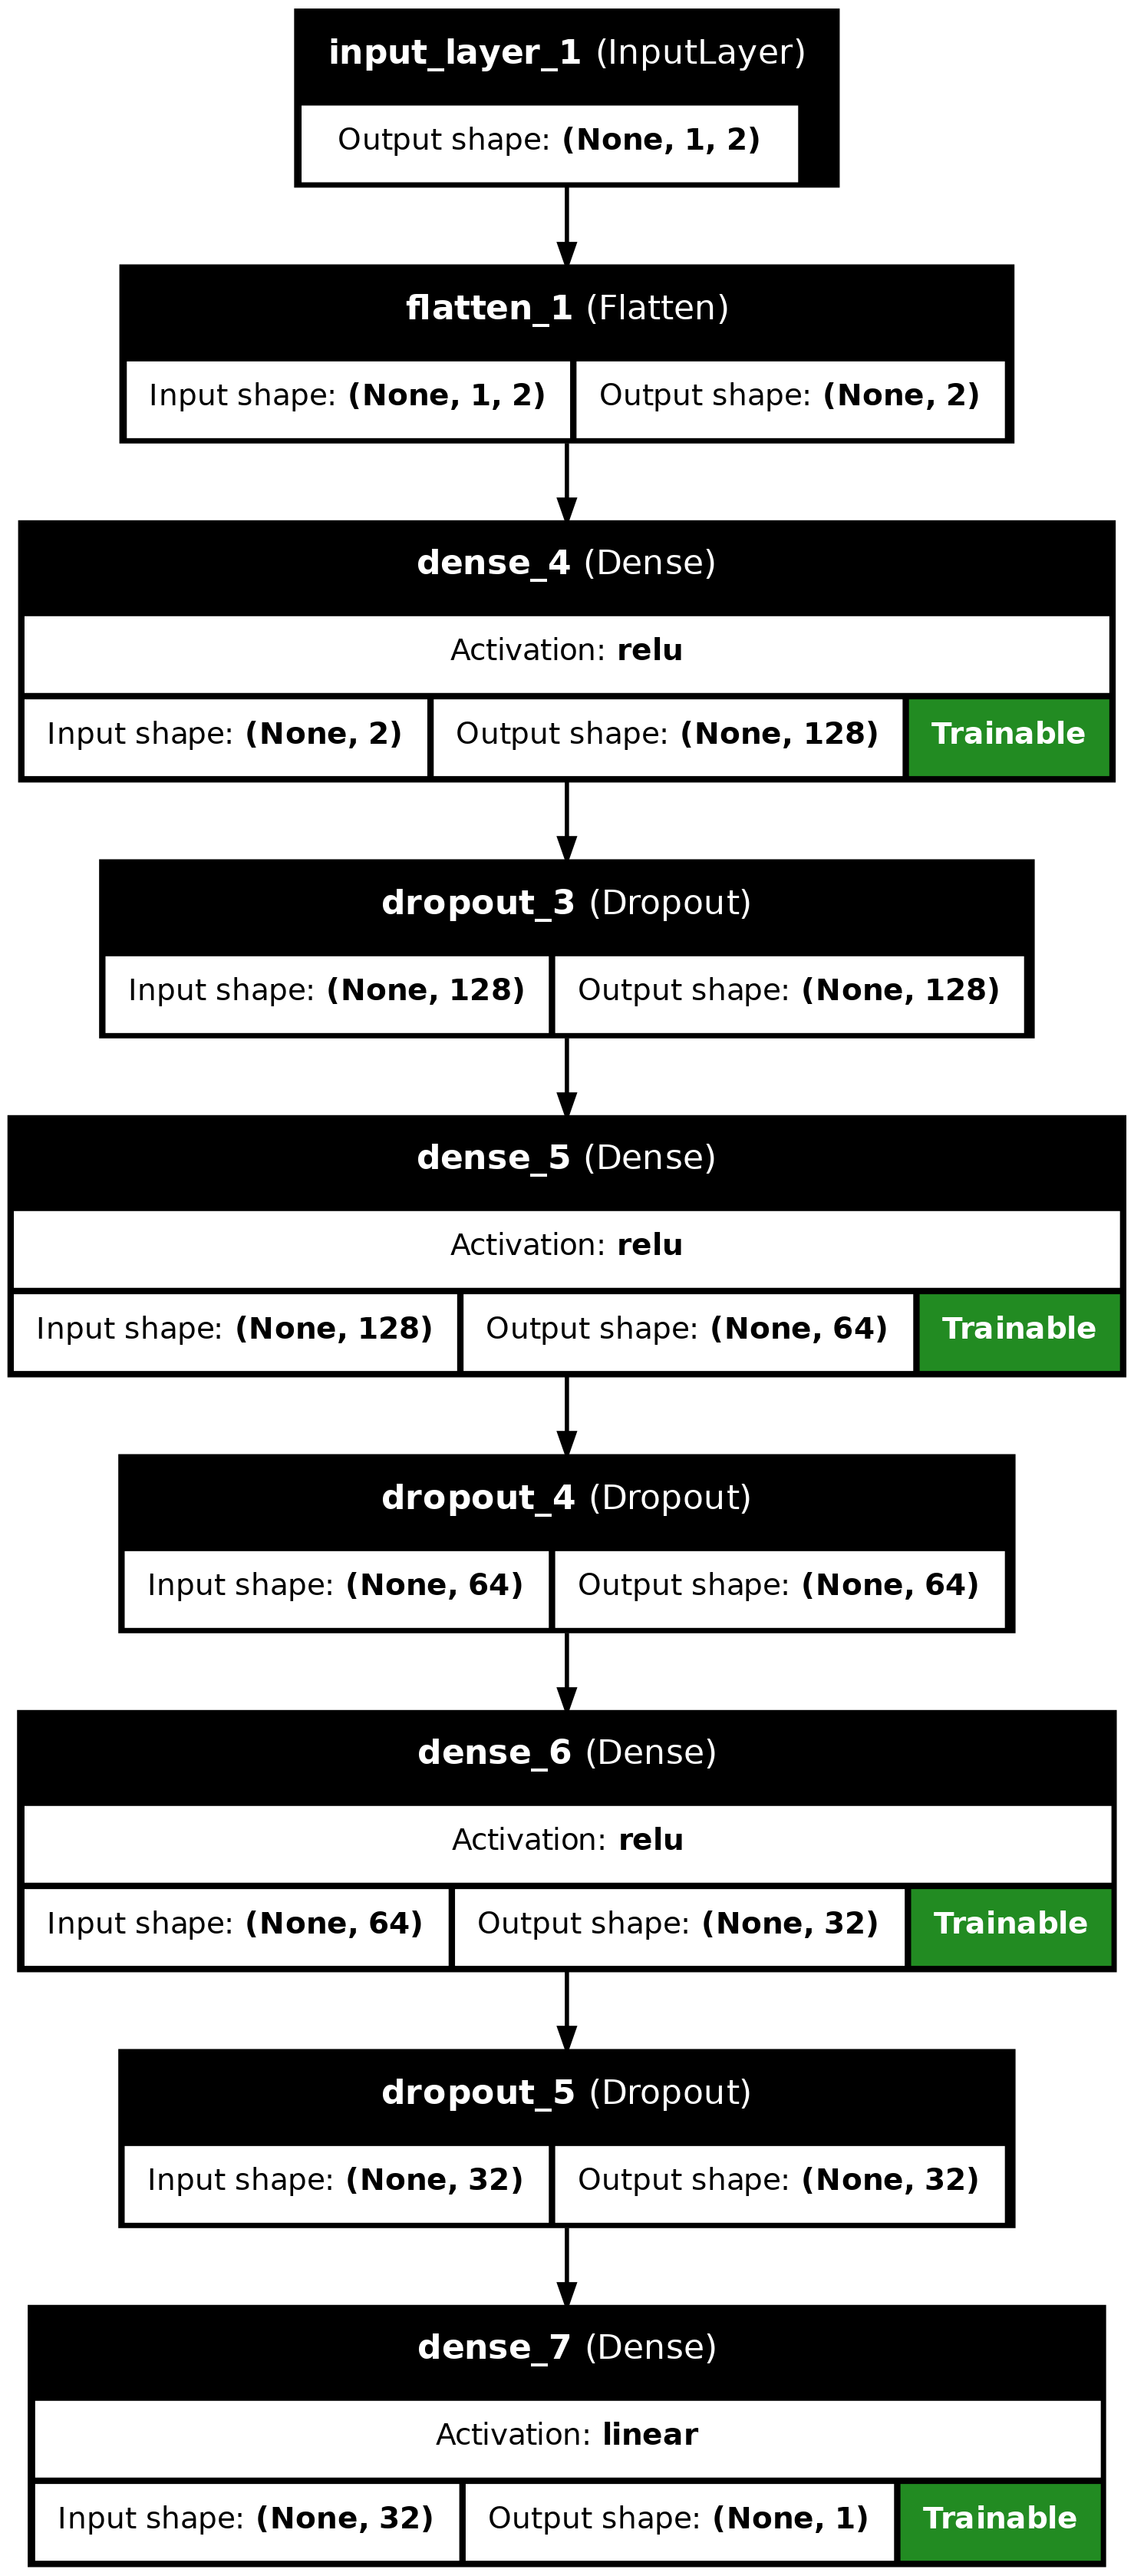

In [ ]:
MODELS_IMAGES_PATH = '../reports/images/models/'
model = create_model_MLP(
    input_shape=(1,2),
    num_classes=None
    )

display(plot_model(model, to_file=MODELS_IMAGES_PATH + 'model_MLP_graph.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True, expand_nested=True))

In [16]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,753 (42.00 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 0 (0.00 B)